In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
GaussianMix = GaussianMixture.symmetric_2D(4,1.0)

gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer = FlowDiffTrainer(path=gaussian_path, modeltype="Diffusion", model=model1)

trainer.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 5.697951793670654
In Epoch 1000 we have a loss of 14.402706146240234
In Epoch 2000 we have a loss of 26.5620174407959
In Epoch 3000 we have a loss of 4.282751083374023
In Epoch 4000 we have a loss of 4.708257675170898
In Epoch 5000 we have a loss of 14.073948860168457
In Epoch 6000 we have a loss of 4.742974281311035
In Epoch 7000 we have a loss of 4.967984676361084
In Epoch 8000 we have a loss of 5.751862049102783
In Epoch 9000 we have a loss of 6.3721184730529785
In Epoch 10000 we have a loss of 19.98855972290039
In Epoch 11000 we have a loss of 6.307516574859619
In Epoch 12000 we have a loss of 5.4719672203063965
In Epoch 13000 we have a loss of 6.213458061218262
In Epoch 14000 we have a loss of 15.178267478942871
In Epoch 15000 we have a loss of 6.340122699737549
In Epoch 16000 we have a loss of 5.950395107269287
In Epoch 17000 we have a loss of 5.993605136871338
In Epoch 18000 we have a loss of 11.778730392456055
In Epoch 19000 we have a loss of 5.7617

In [3]:
rec1 = RectangleDataset(device=device, coords= [(-5.0,5.0),(-10,10)])

gaussian_path2 = GaussianConditionalProbabilityPath(p_data=rec1, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model2 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer2 = FlowDiffTrainer(path=gaussian_path2, modeltype="Diffusion", model=model2)

trainer2.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 6.16781759262085
In Epoch 1000 we have a loss of 16.233989715576172
In Epoch 2000 we have a loss of 10.466782569885254
In Epoch 3000 we have a loss of 6.5716681480407715
In Epoch 4000 we have a loss of 5.846301555633545
In Epoch 5000 we have a loss of 5.795733451843262
In Epoch 6000 we have a loss of 5.947579860687256
In Epoch 7000 we have a loss of 7.856250286102295
In Epoch 8000 we have a loss of 6.262946128845215
In Epoch 9000 we have a loss of 6.6920881271362305
In Epoch 10000 we have a loss of 12.6494722366333
In Epoch 11000 we have a loss of 4.132572174072266
In Epoch 12000 we have a loss of 17.749069213867188
In Epoch 13000 we have a loss of 6.736570358276367
In Epoch 14000 we have a loss of 7.120779514312744
In Epoch 15000 we have a loss of 9.54638957977295
In Epoch 16000 we have a loss of 6.998780250549316
In Epoch 17000 we have a loss of 17.42119598388672
In Epoch 18000 we have a loss of 15.593122482299805
In Epoch 19000 we have a loss of 8.995121

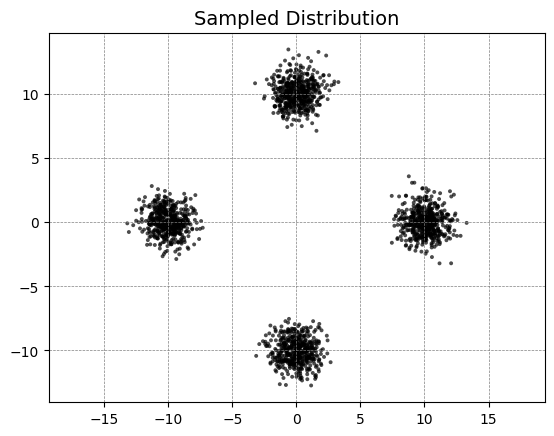

In [4]:
plot_samples(GaussianMix.sample(2000))
plt.show()

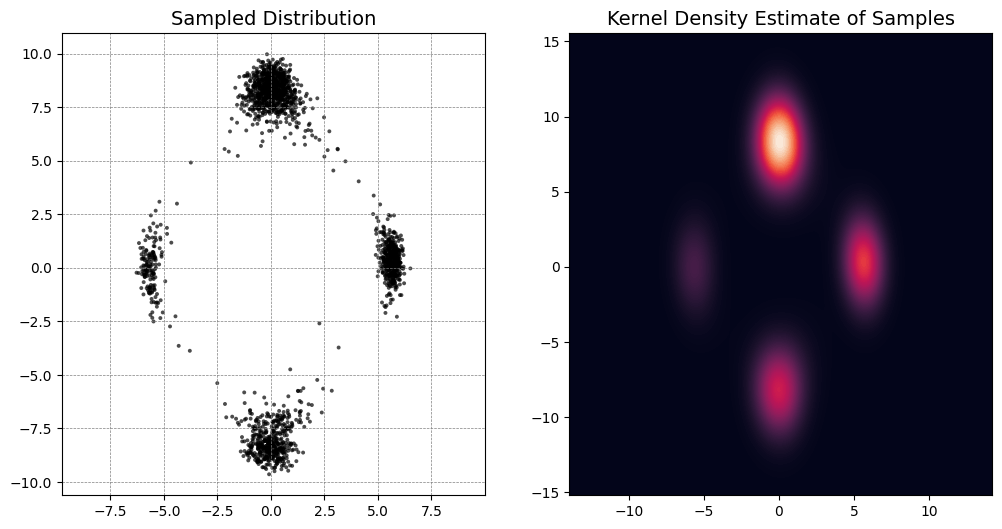

In [5]:
models = [model1,model2]

sde = CompLangevin(models=models, sigma = 0.5, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 
samples = comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps)
figsize=(12, 6)

fig, axes = plt.subplots(1, 2, figsize = figsize)
plot_samples(samples, ax=axes[0], kde=True)
plot_kde(samples, ax = axes[1], cmap="rocket")

plt.show()

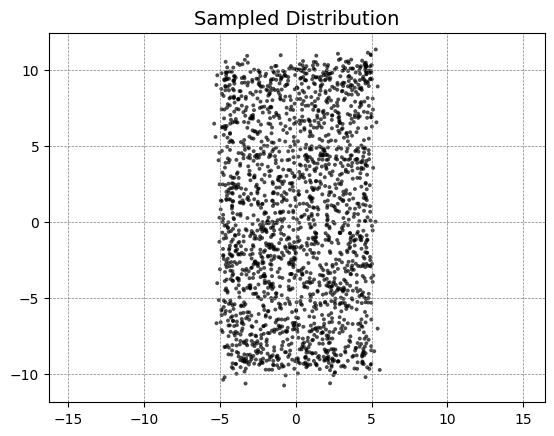

In [6]:
models = [model2]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.05, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps),contour=False)

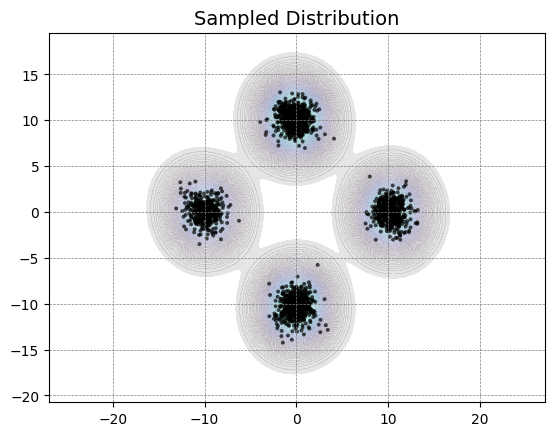

In [7]:
models = [model1]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_with_traj(gaussian_path.p_init.sample(2000), steps)[-1], scatter=True,kde=True)